# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
#from tensorflow.keras.utils import to_categorical # Utilizaré esta por conveniencia para One-Hot Encoding
from collections import Counter # Para el conteo de clases
import warnings
warnings.filterwarnings('ignore') # Ocultar advertencias de Pandas/sklearn

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando device:", device)

# Esto obliga a W&B a usar C:\wandb_temp en lugar de la ruta bloqueada de AppData.
os.environ["WANDB_DATA_DIR"] = "C:\\wandb_temp" 
print(f"DEBUG: WANDB_DATA_DIR ha sido forzada a: {os.environ['WANDB_DATA_DIR']}")

import wandb
wandb.login() 

# Definición del mapeo de etiquetas
label_map = {0: 'N (Normal)', 1: 'S (Supraventricular)', 2: 'V (Ventricular)', 3: 'F (Fusionado)', 4: 'Q (Desconocido)'}

Usando device: cuda
DEBUG: WANDB_DATA_DIR ha sido forzada a: C:\wandb_temp


wandb: Currently logged in as: kidnixt (kidnixt-ort) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# Carga del Dataset

In [14]:
# Carga de los datasets
try:
    df_train = pd.read_csv('train/mitbih_train.csv', header=None)
    df_test = pd.read_csv('test/mitbih_test.csv', header=None)
except FileNotFoundError:
    print("Error: Asegúrate de que los archivos 'mitbih_train.csv' y 'mitbih_test.csv' estén en el directorio correcto.")
    # Si estás en Colab, deberás montar Google Drive o subir los archivos.
    
# Separación de features (X) y etiquetas (y)
X_train = df_train.iloc[:, :-1].copy()  # Señales (columnas 0 a 186)
y_train = df_train.iloc[:, -1].copy()   # Etiquetas (columna 187)

X_test = df_test.iloc[:, :-1].copy()
y_test = df_test.iloc[:, -1].copy()

print(f"✅ Datos de Entrenamiento cargados. Forma de X_train: {X_train.shape}")
print(f"✅ Datos de Prueba cargados. Forma de X_test: {X_test.shape}")

✅ Datos de Entrenamiento cargados. Forma de X_train: (87554, 187)
✅ Datos de Prueba cargados. Forma de X_test: (21892, 187)


# 1. Análisis Exploratorio de Datos (EDA)

## Visualización Forma de las Señales

Visualizando una muestra de latido para cada una de las 5 clases:


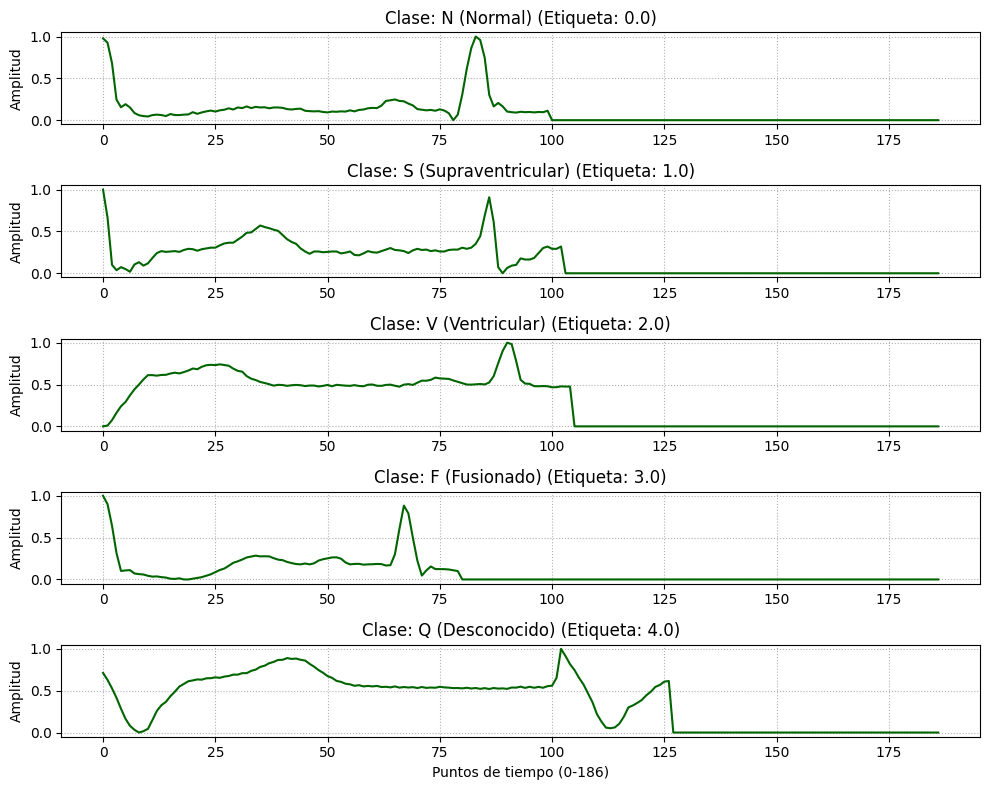

In [3]:
plt.figure(figsize=(10, 8))
classes = sorted(y_train.unique())

print("Visualizando una muestra de latido para cada una de las 5 clases:")

for i, class_label in enumerate(classes):
    plt.subplot(len(classes), 1, i + 1)
    
    # Encontrar el índice de la primera ocurrencia
    sample_index = y_train[y_train == class_label].index[0]
    
    # Obtener la señal
    signal = X_train.loc[sample_index]
    
    plt.plot(signal, color='darkgreen')
    plt.title(f'Clase: {label_map[class_label]} (Etiqueta: {class_label})', fontsize=12)
    plt.ylabel('Amplitud')
    plt.grid(True, linestyle=':')

plt.xlabel('Puntos de tiempo (0-186)')
plt.tight_layout()
plt.show()

## Desbalanceo de Clases

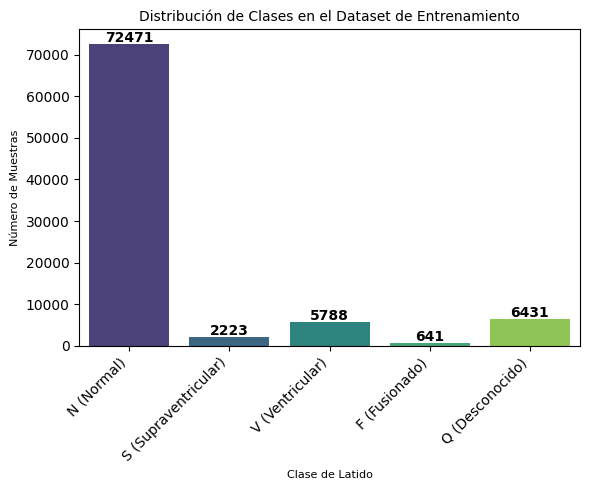


La Clase 0 (Normal) representa el 82.77% del dataset.


In [4]:
class_counts = y_train.value_counts().sort_index()
total_samples = class_counts.sum()
normal_percentage = (class_counts[0] / total_samples) * 100

plt.figure(figsize=(6, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")

plt.xticks(ticks=class_counts.index, labels=[label_map[i] for i in class_counts.index], rotation=45, ha='right')

plt.title('Distribución de Clases en el Dataset de Entrenamiento', fontsize=10)
plt.xlabel('Clase de Latido', fontsize=8)
plt.ylabel('Número de Muestras', fontsize=8)

for index, value in enumerate(class_counts):
    plt.text(index, value + 500, f'{value}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nLa Clase 0 (Normal) representa el {normal_percentage:.2f}% del dataset.")

## Análisis Estadístico

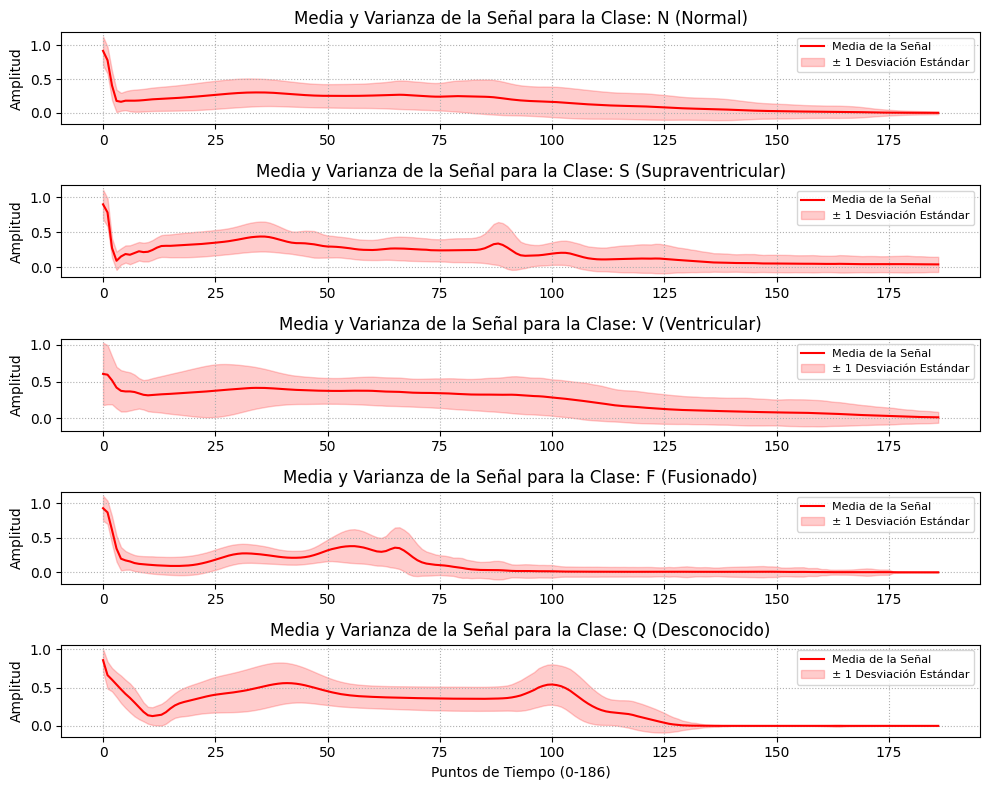

In [5]:
plt.figure(figsize=(10, 8))

# Agrupar los datos de entrenamiento por clase
grouped_data = df_train.groupby(187) 

# Iterar sobre cada clase para calcular y graficar estadísticas
for i, class_label in enumerate(sorted(y_train.unique())):
    plt.subplot(5, 1, i + 1)
    
    # Seleccionar las señales para la clase actual
    signals_class = grouped_data.get_group(class_label).iloc[:, :-1]
    
    # Calcular la media y la desviación estándar a lo largo del eje de tiempo (columnas)
    mean_signal = signals_class.mean(axis=0)
    std_signal = signals_class.std(axis=0)
    
    time_points = np.arange(signals_class.shape[1])
    
    # Graficar la media
    plt.plot(time_points, mean_signal, label='Media de la Señal', color='red')
    
    # Rellenar el área de +/- 1 desviación estándar para mostrar la varianza
    plt.fill_between(time_points, mean_signal - std_signal, mean_signal + std_signal, 
                     color='red', alpha=0.2, label='± 1 Desviación Estándar')
    
    plt.title(f'Media y Varianza de la Señal para la Clase: {label_map[class_label]}', fontsize=12)
    plt.ylabel('Amplitud')
    plt.grid(True, linestyle=':')
    plt.legend(loc='upper right', fontsize=8)

plt.xlabel('Puntos de Tiempo (0-186)')
plt.tight_layout()
plt.show()


## Distribución de Amplitudes Promedio

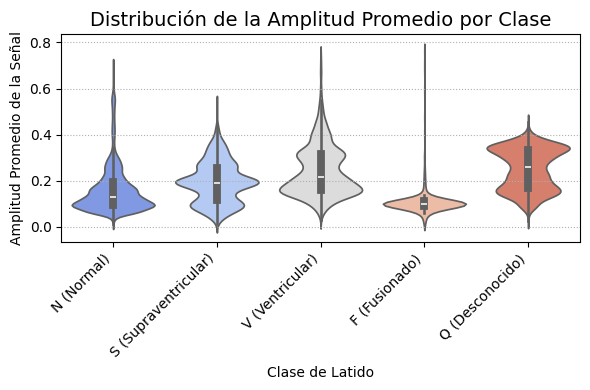

In [6]:
X_train['mean_amplitude'] = X_train.mean(axis=1)

plt.figure(figsize=(6, 4))

# Usar un violín plot para comparar distribuciones
sns.violinplot(x=y_train, y=X_train['mean_amplitude'], palette="coolwarm")

# Ajustar etiquetas
plt.xticks(ticks=y_train.unique(), labels=[label_map[i] for i in sorted(y_train.unique())], rotation=45, ha='right')
plt.title('Distribución de la Amplitud Promedio por Clase', fontsize=14)
plt.xlabel('Clase de Latido')
plt.ylabel('Amplitud Promedio de la Señal')
plt.grid(axis='y', linestyle=':')
plt.tight_layout()
plt.show()

# Eliminar la columna temporal
X_train = X_train.drop(columns=['mean_amplitude'])


## Correlación entre puntos

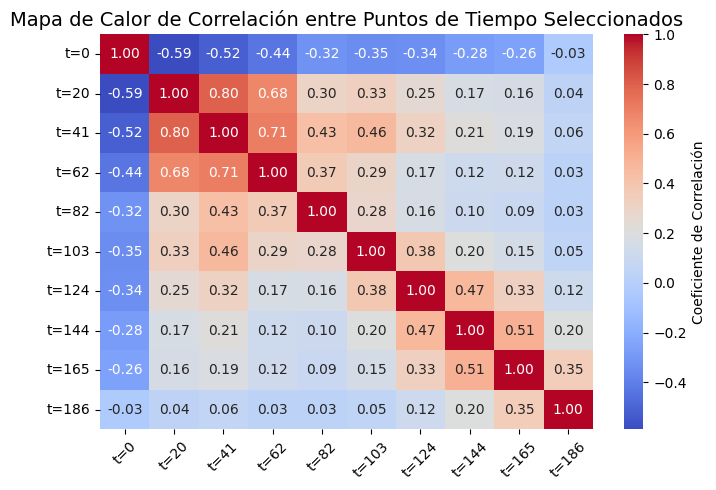

In [7]:
# Seleccionar 10 puntos de tiempo espaciados uniformemente (características)
num_features = X_train.shape[1]
time_indices = np.linspace(0, num_features - 1, 10, dtype=int) 
selected_features = X_train.iloc[:, time_indices]

# Calcular la matriz de correlación
correlation_matrix = selected_features.corr()

plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            cbar_kws={'label': 'Coeficiente de Correlación'})

# Personalizar etiquetas
tick_labels = [f't={i}' for i in time_indices]
plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels, rotation=45)
plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels, rotation=0)

plt.title('Mapa de Calor de Correlación entre Puntos de Tiempo Seleccionados', fontsize=14)
plt.tight_layout()
plt.show()


## Histograma de Amplitudes

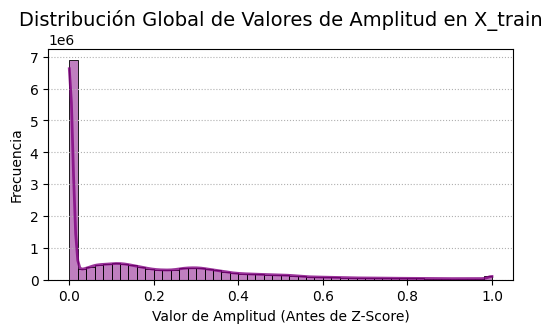

In [8]:
all_amplitudes = X_train.values.flatten()

plt.figure(figsize=(6, 3))
# Usar histplot para generar el histograma
sns.histplot(all_amplitudes, bins=50, kde=True, color='purple', 
             line_kws={'linewidth': 2, 'alpha': 0.8})

plt.title('Distribución Global de Valores de Amplitud en X_train', fontsize=14)
plt.xlabel('Valor de Amplitud (Antes de Z-Score)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle=':')
plt.show()


# 2. Insights del EDA


## Desafío Crítico: Desbalanceo de Clases

| Detalle | Decisión de Implementación (PyTorch) | Justificación (Análisis 3) |
| :--- | :--- | :--- |
| **Relación de Clases** | La clase **N (Normal)** (82.77%) domina, con una relación de **113:1** respecto a la clase **F (Fusionado)** (0.73%). | Un modelo sin mitigación predeciría ciegamente 'N', dando un *Accuracy* alto pero fallando en la detección de arritmias (clases minoritarias). |
| **Estrategia** | **`nn.CrossEntropyLoss` con `class_weights`**. Los pesos son inversamente proporcionales a la frecuencia de cada clase. | Esto obliga al modelo a penalizar fuertemente los errores en las clases raras (S, F), forzando el aprendizaje de sus características. |
| **Métricas** | Evaluación basada en **F1-Macro**, **Precision** y **Recall** por clase. | El *Accuracy* es engañoso. El F1-Macro proporciona una medida robusta de la capacidad predictiva en *todas* las clases. |

---

## Desafío de la Amplitud y Convergencia

| Detalle | Decisión de Implementación (PyTorch) | Justificación (Análisis 7) |
| :--- | :--- | :--- |
| **Distribución Global** | El histograma de amplitudes muestra un pico extremo en $0.0$, y aunque el rango es $[0, 1]$, los datos no están centrados. | El entrenamiento de redes profundas converge más rápido y de forma más estable cuando los datos de entrada están **centrados en cero** ($media=0$). |
| **Estrategia** | **Normalización Z-Score Global**. Fórmula: $\text{Señal}_{\text{norm}} = (\text{Señal} - \mu_{\text{global}}) / \sigma_{\text{global}}$. | Se calcula la media ($\mu$) y desviación estándar ($\sigma$) de **todo** el conjunto de entrenamiento para estandarizar la escala. Esto evita la saturación de las neuronas RNN. |

---

## Justificación de la Arquitectura Recurrente (LSTM/GRU)

| Detalle | Decisión de Implementación (PyTorch) | Justificación (Análisis 4 y 6) |
| :--- | :--- | :--- |
| **Naturaleza del Dato** | La forma de onda es una **Serie de Tiempo**; las arritmias son patrones que se desarrollan en el tiempo (187 puntos). | Un **MLP** (Red *Feedforward*) ignora la secuencia. La **LSTM/GRU** es esencial porque su memoria interna puede capturar dependencias a corto plazo (correlación local) y a largo plazo (la forma completa del latido). |
| **Profundidad** | Se utilizará una arquitectura con **dos o más capas recurrentes** apiladas (`num_layers > 1`). | Las capas múltiples permiten al modelo aprender **jerarquías**: la primera capa capta rasgos básicos de la señal y las siguientes integran esos rasgos en patrones temporales más complejos y específicos de cada arritmia. |

# 3. Preprocesamiento y DataLoaders

In [15]:
X_train_np = X_train.values
GLOBAL_MEAN = X_train_np.mean()
GLOBAL_STD = X_train_np.std()

# 2.2. Cálculo de Pesos de Clase (class_weights) (Análisis 3)
# La clase 0 (Normal) representa el 82.77% y la clase 3 (Fusionado) el 0.73%.
# Usamos el inverso de la frecuencia.
train_counts = Counter(y_train.values)
total_samples = sum(train_counts.values())
num_classes = len(train_counts)

# Los pesos se calculan como: 1 / frecuencia_relativa
# Para balancear la balanza, usamos el peso más alto (el de la clase más rara) como base.
max_count = max(train_counts.values())
class_weights = torch.zeros(num_classes, dtype=torch.float32)

for i in range(num_classes):
    # Peso = max_count / count_de_la_clase
    class_weights[i] = max_count / train_counts.get(i, 1) # Usar 1 por si una clase falta (no debería pasar)

# Normalizar los pesos para que el tensor de pérdida se inicialice bien
class_weights = class_weights / class_weights.sum()

print("--- Constantes de Preprocesamiento Calculadas ---")
print(f"Media Global (mu): {GLOBAL_MEAN:.6f}")
print(f"Desviación Estándar Global (sigma): {GLOBAL_STD:.6f}")
print(f"Pesos de Clase Inversos (para nn.CrossEntropyLoss):")
for i, weight in enumerate(class_weights):
    print(f"  Clase {i} (Peso: {weight:.4f})")



--- Constantes de Preprocesamiento Calculadas ---
Media Global (mu): 0.174283
Desviación Estándar Global (sigma): 0.226327
Pesos de Clase Inversos (para nn.CrossEntropyLoss):
  Clase 0 (Peso: 0.0059)
  Clase 1 (Peso: 0.1913)
  Clase 2 (Peso: 0.0735)
  Clase 3 (Peso: 0.6633)
  Clase 4 (Peso: 0.0661)


In [16]:
# --- 3. DEFINICIÓN DEL DATASET DE PYTORCH ---

class ECGDataset(Dataset):
    """
    Clase de Dataset personalizada para datos de ECG en PyTorch.
    Aplica Normalización Z-Score y reformatea la señal.
    """
    def __init__(self, X, y, mean, std):
        # Conversión a NumPy (si viene de Pandas) y a Float32
        self.X = X.values.astype(np.float32)
        self.y = y.values

        # Constantes de Normalización Z-Score
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # 1. Obtener la señal y la etiqueta
        signal = self.X[idx]
        label = self.y[idx]

        # 2. Aplicar Normalización Z-Score (Decisión del Análisis 7)
        if self.std != 0:
            signal = (signal - self.mean) / self.std
        
        # 3. Reformatear la señal a (L, H) = (187, 1) para la RNN
        # Las RNNs en PyTorch esperan (batch_size, sequence_length, input_size)
        # O (sequence_length, batch_size, input_size)
        # Aquí la reformateamos a (187, 1) para que el DataLoader la convierta a (B, 187, 1)
        # El input_size es 1 porque es una serie de tiempo univariada.
        signal_tensor = torch.tensor(signal, dtype=torch.float32).unsqueeze(-1)
        
        # 4. Convertir la etiqueta a tensor
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        return signal_tensor, label_tensor


In [17]:
# NOTA: Los datos de Test (X_test, y_test) se usarán como el conjunto final.
# La validación (X_val, y_val) se extrae del conjunto de entrenamiento original (X_train, y_train).

# 1. Definir el tamaño de la validación (usaremos un 20% del total de entrenamiento original)
# El conjunto de entrenamiento original es de 87554 muestras. El 20% es ~17511.
VAL_SIZE = 0.2
RANDOM_SEED = 42

# 2. División de X_train/y_train en X_train_new/y_train_new y X_val/y_val
X_train_new, X_val, y_train_new, y_val = train_test_split(
    X_train, y_train,
    test_size=VAL_SIZE,
    random_state=RANDOM_SEED,
    # El stratify es CRÍTICO: asegura que el desbalanceo se mantenga en los tres conjuntos.
    stratify=y_train 
)

print("--- División de Datos Completada ---")
print(f"X_train (nuevo) size: {X_train_new.shape[0]} muestras")
print(f"X_val size: {X_val.shape[0]} muestras")
print(f"X_test size: {X_test.shape[0]} muestras (Sin tocar)")



--- División de Datos Completada ---
X_train (nuevo) size: 70043 muestras
X_val size: 17511 muestras
X_test size: 21892 muestras (Sin tocar)


In [18]:
def get_dataloaders(batch_size=2048, num_workers=0, pin_memory=None, verbose=True):
    """
    Crea y devuelve (train_loader, val_loader, test_loader) usando las variables definidas
    en el notebook: X_train_new, y_train_new, X_val, y_val, X_test, y_test, GLOBAL_MEAN, GLOBAL_STD.
    """
    # Crear datasets (usa la clase ECGDataset ya definida)
    train_dataset = ECGDataset(X_train_new, y_train_new, GLOBAL_MEAN, GLOBAL_STD)
    val_dataset = ECGDataset(X_val, y_val, GLOBAL_MEAN, GLOBAL_STD)
    test_dataset = ECGDataset(X_test, y_test, GLOBAL_MEAN, GLOBAL_STD)

    # Determinar pin_memory por defecto si no se especifica
    if pin_memory is None:
        pin_memory = torch.cuda.is_available()

    # Crear DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    if verbose:
        print("\n--- Verificación de Estructura de DataLoaders ---")
        print(f"Batches de Entrenamiento (train_loader): {len(train_loader)}")
        print(f"Batches de Validación (val_loader): {len(val_loader)}")
        print(f"Batches de Prueba (test_loader): {len(test_loader)}")

        # Inspección de un batch de Validación
        for signals, labels in val_loader:
            print(f"\nTensor de Validación (Batch): {signals.shape}")
            print("Formato esperado para RNN/LSTM: (BATCH_SIZE, 187, 1)")
            break

    return train_loader, val_loader, test_loader

In [19]:
train_loader, val_loader, test_loader = get_dataloaders()


--- Verificación de Estructura de DataLoaders ---
Batches de Entrenamiento (train_loader): 35
Batches de Validación (val_loader): 9
Batches de Prueba (test_loader): 11

Tensor de Validación (Batch): torch.Size([2048, 187, 1])
Formato esperado para RNN/LSTM: (BATCH_SIZE, 187, 1)


In [20]:
# --- CÓDIGO DE VERIFICACIÓN DE NORMALIZACIÓN Z-SCORE ---

# Tomamos un solo batch del DataLoader de entrenamiento
for signals, labels in train_loader:
    # signals es el tensor con la forma (Batch Size, Sequence Length, Input Size) -> (64, 187, 1)
    
    # Aplanamos el tensor para inspeccionar todos los valores en el batch
    all_values_in_batch = signals.flatten()
    
    # Calculamos la media y la desviación estándar de este batch
    batch_mean = all_values_in_batch.mean().item()
    batch_std = all_values_in_batch.std().item()

    print("\n--- Verificación de Normalización en el Primer Batch ---")
    print(f"Media del Batch (Esperado ~ 0.0): {batch_mean:.6f}")
    print(f"Desviación Estándar del Batch (Esperado ~ 1.0): {batch_std:.6f}")
    
    # Comprobación simple para confirmar la normalización
    if abs(batch_mean) < 0.01 and abs(batch_std - 1.0) < 0.05:
        print("✅ Resultado: La Normalización Z-Score parece ser correcta.")
    else:
        print("❌ Advertencia: La media o la desviación están fuera del rango esperado. Revisar GLOBAL_MEAN/GLOBAL_STD.")
        
    break # Solo necesitamos inspeccionar el primer batch

# Puedes imprimir también el rango (Min y Max) para ver que los valores se han extendido.
print(f"Valor Mínimo en el Batch: {all_values_in_batch.min().item():.4f}")
print(f"Valor Máximo en el Batch: {all_values_in_batch.max().item():.4f}")


--- Verificación de Normalización en el Primer Batch ---
Media del Batch (Esperado ~ 0.0): -0.006044
Desviación Estándar del Batch (Esperado ~ 1.0): 0.990931
✅ Resultado: La Normalización Z-Score parece ser correcta.
Valor Mínimo en el Batch: -0.7700
Valor Máximo en el Batch: 3.6483


# 4. Funciones Génericas

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
import time
import wandb
from tqdm import tqdm
import os
import sys

def train_model(model, train_loader, val_loader, config, device, class_weights, patience=10):
    """
    Entrena y evalúa un modelo para ECG, registrando métricas en Wandb.
    Utiliza F1-Macro y Early Stopping basado en Val F1-Macro.
    
    Args:
        model (nn.Module): El modelo PyTorch a entrenar (LSTM o GRU).
        train_loader (DataLoader): DataLoader para entrenamiento.
        val_loader (DataLoader): DataLoader para validación.
        config (dict): Diccionario de hiperparámetros (de wandb.config).
        device (torch.device): Dispositivo (CPU/CUDA).
        class_weights (torch.Tensor): Pesos inversos de clase para CrossEntropyLoss.
        patience (int): Épocas para Early Stopping.
    """
    model = model.to(device)
    
    # Configuración de Pérdida y Optimizador
    # CrossEntropyLoss con Pesos de Clase (CRÍTICO para el desbalanceo)
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    
    wd = config.get("weight_decay", 0.0) 

    if config["optimizer"] == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=config["lr"], weight_decay=wd) 
    elif config["optimizer"] == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=0.9, weight_decay=wd)
    else:
        raise ValueError(f"Optimizer {config['optimizer']} no soportado.")

    best_val_f1_macro = -1.0 # Queremos MAXIMIZAR
    patience_counter = 0
    
    # Crear carpeta para guardar modelos si no existe
    os.makedirs("models", exist_ok=True) 

    for epoch in range(config["epochs"]):
        start_epoch = time.time()
        
        # --- BUCLE DE ENTRENAMIENTO ---
        model.train()
        running_loss, all_preds, all_labels = 0.0, [], []

        for signals, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']} [TRAIN]", leave=False):
            signals, labels = signals.to(device), labels.to(device)

            optimizer.zero_grad(set_to_none=True)
            outputs = model(signals)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Acumular métricas
            running_loss += loss.detach().item() * signals.size(0)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader.dataset)
        train_f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        
        # --- BUCLE DE VALIDACIÓN ---
        model.eval()
        running_val_loss, all_val_preds, all_val_labels = 0.0, [], []
        
        with torch.no_grad():
            for signals, labels in val_loader:
                signals, labels = signals.to(device), labels.to(device)
                outputs = model(signals)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * signals.size(0)
                _, predicted = torch.max(outputs.data, 1)
                all_val_preds.extend(predicted.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        val_loss = running_val_loss / len(val_loader.dataset)
        val_f1_macro = f1_score(all_val_labels, all_val_preds, average='macro', zero_division=0)
        
        end_epoch = time.time()

        # Log W&B
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_f1_macro": train_f1_macro,
            "val_loss": val_loss,
            "val_f1_macro": val_f1_macro,
        })
        
        # Impresión concisa en consola
        sys.stdout.write(f"\rEpoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Train F1: {train_f1_macro:.4f} | Val F1: {val_f1_macro:.4f} | ⏱️ {end_epoch - start_epoch:.1f}s")
        sys.stdout.flush()

        # Early stopping (Basado en Val F1-Macro)
        if val_f1_macro > best_val_f1_macro:
            best_val_f1_macro = val_f1_macro
            patience_counter = 0
            # Guardar el mejor modelo localmente
            torch.save(model.state_dict(), f"models/best_sweep_run_{wandb.run.id}.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\n⏹ Early stopping en epoch {epoch+1}. Mejor Val F1-Macro: {best_val_f1_macro:.4f}")
                break

    # Guardar la mejor métrica final para el summary de Wandb
    wandb.run.summary["best_val_f1_macro"] = best_val_f1_macro
    return model, {"best_val_f1_macro": best_val_f1_macro}

In [42]:
import torch
import torch.nn as nn
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
def evaluate_model(model, data_loader, device, class_weights=None, data_split='Test', class_names=['N', 'S', 'V', 'F', 'Q']):
    """
    Evalúa un modelo, calcula métricas, registra en W&B y plotea la Matriz de Confusión localmente.
    """
    model.eval()
    
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device) if class_weights is not None else None)
    
    running_loss = 0.0
    all_preds = []
    all_labels = []
    total = 0
    
    print(f"\nIniciando evaluación en el conjunto: {data_split}...")

    with torch.no_grad():
        for signals, labels in data_loader:
            signals, labels = signals.to(device), labels.to(device)
            
            outputs = model(signals)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * signals.size(0)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)

    # 1. Calcular métricas finales
    final_loss = running_loss / total
    final_acc = accuracy_score(all_labels, all_preds)
    final_f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    # 2. Matriz de Confusión (CM)
    cm = confusion_matrix(all_labels, all_preds)

    # 3. Classification report (string)
    classif_report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0)
    print("\nClassification Report:\n")
    print(classif_report)

    metrics = {
        f"{data_split}_loss": final_loss,
        f"{data_split}_accuracy": final_acc,
        f"{data_split}_f1_macro": final_f1_macro,
        f"{data_split}_confusion_matrix": cm.tolist(),
        f"{data_split}_classification_report": classif_report
    }


    # 4. PLOTEO LOCAL CON MATPLOTLIB/SEABORN 🖼️
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, 
        annot=True,              # Mostrar los números en las celdas
        fmt='d',                 # Formato para números enteros
        cmap='Blues',            # Esquema de color
        xticklabels=class_names, # Etiquetas del eje X (Predicciones)
        yticklabels=class_names  # Etiquetas del eje Y (Verdaderas)
    )
    plt.title(f'Matriz de Confusión - {data_split}')
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.show() # Muestra el gráfico

    print(f"--- Resultados Finales ({data_split}) ---")
    print(f"Loss: {final_loss:.4f}")
    print(f"Accuracy: {final_acc:.4f}")
    print(f"F1-Macro: {final_f1_macro:.4f}")
    
    return metrics


In [23]:
import wandb
import json
import re
import os
import wandb.util

def upload_best_model_from_sweep(
    sweep_id: str,
    model_name: str,
    project: str = "heartbeat",
    models_dir: str = "models",
    add_tag: str | None = "best_model",
):
    """
    Busca la mejor run (mínimo val_loss) en un sweep de W&B y sube su modelo como artifact.
    Usa la misma lógica probada que extrajo correctamente los val_loss.

    Args:
        sweep_id (str): ID del sweep (por ejemplo 'abcd1234').
        model_name (str): Nombre lógico del modelo (por ejemplo 'lenet' o 'tinycnn').
        project (str): Nombre del proyecto de W&B (por defecto 'imagenette').
        models_dir (str): Carpeta local donde están los archivos .pth.
        add_tag (str | None): Tag opcional a agregar al artifact.
    """

    api = wandb.Api()
    sweep = api.sweep(f"{project}/{sweep_id}")

    # --- FUNCIÓN ORIGINAL PARA EXTRAER val_loss ---
    def get_val_loss(run):
        """
        Extrae val_loss de una run W&B de forma robusta.
        Siempre devuelve un float (inf si no se encuentra).
        """
        try:
            # 1) intento directo desde summary
            try:
                if hasattr(run, "summary") and getattr(run.summary, "get", None):
                    v = run.summary.get("val_f1_macro")
                    if v is not None:
                        return float(v)
            except Exception:
                pass

            # 2) fallback a _json_dict (puede ser dict o str multiline)
            summary = getattr(run.summary, "_json_dict", None)
            if isinstance(summary, dict):
                v = summary.get("val_f1_macro")
                if v is not None:
                    return float(v)
            elif isinstance(summary, str):
                lines = [l.strip() for l in summary.splitlines() if l.strip()]
                for line in reversed(lines):
                    try:
                        obj = json.loads(line)
                        if "val_f1_macro" in obj:
                            return float(obj["val_f1_macro"])
                    except Exception:
                        m = re.search(r'"val_f1_macro"\s*:\s*([0-9.+-eE]+)', line)
                        if m:
                            return float(m.group(1))
                # última oportunidad: buscar en todo el string
                m = re.search(r'"val_f1_macro"\s*:\s*([0-9.+-eE]+)', summary)
                if m:
                    return float(m.group(1))

        except Exception:
            pass

        # Si todo falla, devolver inf (float) en lugar de None
        return float("inf")

    # --- ELEGIR MEJOR RUN ---
    losses = []
    for run in sweep.runs:
        try:
            l = get_val_loss(run)
        except Exception:
            l = float("inf")
        losses.append((l, run))
        print(f"• {run.name} ({run.id}) → val_f1_macro = {l if l != float('inf') else 'None'}")

    # Elegir la mejor run (la que tenga menor val_f1_macro)
    best_loss, best_run = max(losses, key=lambda x: x[0])
    if best_loss == float("inf"):
        print(f"⚠️ No se pudo extraer val_f1_macro de ninguna run del sweep {sweep_id}.")
        return

    print(f"\n🏆 Mejor run encontrada:")
    print(f"   • Run: {best_run.name} ({best_run.id})")
    print(f"   • val_f1_macro = {best_loss:.4f}")
    print(f"   • Sweep ID: {sweep_id}")

    # --- BUSCAR ARCHIVO DEL MODELO ---
    best_model_path = os.path.join(models_dir, f"sweep_run_{best_run.id}.pth")
    if not os.path.exists(best_model_path):
        print(f"❌ No se encontró el archivo del modelo en {best_model_path}")
        return

    # --- SUBIR ARTIFACT ---
    run_upload = wandb.init(
        project=project,
        # ¡Agrega el parámetro 'id' con un ID único!
        id=wandb.util.generate_id(), 
        name=f"upload_best_{model_name}_{sweep_id}",
        reinit=True,
        tags=["artifact_upload", add_tag] if add_tag else ["artifact_upload"]
    )

    artifact_name = f"{model_name}_best_model_{sweep_id}"
    artifact = wandb.Artifact(
        name=artifact_name,
        type="model",
        description=f"Mejor modelo ({model_name}) del sweep {sweep_id} (run {best_run.id})",
        metadata={
            "sweep_id": sweep_id,
            "run_id": best_run.id,
            "val_f1_macro": best_loss,
        }
    )

    artifact.add_file(best_model_path)
    wandb.log_artifact(artifact)
    wandb.finish()

    print(f"\n✅ Artifact '{artifact_name}' subido correctamente a W&B.")


# 5. Modelo Base LSTM

In [32]:
import torch
import torch.nn as nn

SEQ_LENGTH = 187
INPUT_SIZE = 1
NUM_CLASSES = 5 
BATCH_SIZE = 2048

# --- Decisión de Diseño de Arquitectura (Análisis 4 y 6) ---
HIDDEN_SIZE = 64  # Tamaño del estado oculto (memoria)
NUM_LAYERS = 2    # Profundidad de la LSTM (Justificado por correlación)
DROPOUT_RATE = 0.2 # Regularización para evitar sobreajuste

In [33]:
from types import SimpleNamespace

def build_ecg_lstm(cfg, num_classes=5):
    class ECGClassifier(nn.Module):
        def __init__(self, cfg, num_classes):
            super().__init__()
            self.input_size = cfg.input_size
            self.hidden_size = cfg.hidden_size
            self.num_layers = cfg.num_layers
            self.dropout_rate = cfg.dropout_rate

            # LSTM apilada (batch_first=True)
            self.rnn = nn.LSTM(
                input_size=self.input_size,
                hidden_size=self.hidden_size,
                num_layers=self.num_layers,
                batch_first=True,
                dropout=self.dropout_rate if self.num_layers > 1 else 0.0
            )

            # Clasificador lineal que recibe la salida del último paso temporal
            self.classifier = nn.Linear(self.hidden_size, num_classes)

        def forward(self, x):
            # x: (batch_size, seq_length, input_size)
            # inicializar h0, c0 usando el mismo device y dtype que x
            h0 = x.new_zeros(self.num_layers, x.size(0), self.hidden_size)
            c0 = x.new_zeros(self.num_layers, x.size(0), self.hidden_size)

            out, (h_n, c_n) = self.rnn(x, (h0, c0))
            out_last = out[:, -1, :]            # (batch_size, hidden_size)
            logits = self.classifier(out_last)  # (batch_size, num_classes)
            return logits

    return ECGClassifier(cfg, num_classes=num_classes)

# Configuración equivalente a tus constantes
config = SimpleNamespace(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout_rate=DROPOUT_RATE,
)

model = build_ecg_lstm(config, num_classes=NUM_CLASSES)
from torchinfo import summary
summary(model, input_size=(BATCH_SIZE, SEQ_LENGTH, INPUT_SIZE))


Layer (type:depth-idx)                   Output Shape              Param #
ECGClassifier                            [2048, 5]                 --
├─LSTM: 1-1                              [2048, 187, 64]           50,432
├─Linear: 1-2                            [2048, 5]                 325
Total params: 50,757
Trainable params: 50,757
Non-trainable params: 0
Total mult-adds (G): 19.31
Input size (MB): 1.53
Forward/backward pass size (MB): 196.17
Params size (MB): 0.20
Estimated Total Size (MB): 197.90

## Selección de Hiperparámetros

In [15]:
def sweep_train():
    """
    Ejecuta un sweep de W&B usando DataLoaders pre-cargados en RAM.
    Sin prints de debug innecesarios.
    """
    wandb.init(
        project="heartbeat", 
        config=wandb.config,
        settings=wandb.Settings(console="off"),
        tags=["BASELINE_LSTM"]
    )
    
    config = wandb.config

    # Construir modelo
    model = build_ecg_lstm(config).to(device)

    train_loader, val_loader, test_loader = get_dataloaders(
        batch_size=config.batch_size, num_workers=0
    )

    # Entrenamiento
    best_model, history = train_model(
        model, train_loader, val_loader, config, device, patience=7, class_weights=class_weights
    )

    # Guardar modelo
    os.makedirs("models", exist_ok=True)
    local_path = f"models/sweep_run_{wandb.run.id}.pth"
    torch.save(best_model.state_dict(), local_path)

    wandb.finish()


In [ ]:

sweep_config = {
    "name": "lstm_sweep_baseline",
    "method": "bayes",
    # Usamos val_f1_macro (que tu train_model loggea) y queremos MAXIMIZARla
    "metric": {"name": "val_f1_macro", "goal": "maximize"},
    "parameters": {
        "input_size": {"value": 1},  # <- fijo para tu LSTM univariada

        "lr": {
            "distribution": "log_uniform_values",
            # Se ajusta el rango para priorizar el entorno de la convergencia inicial
            "min": 5e-4, 
            "max": 5e-3 
        },
        # Optimizador: Adam suele funcionar bien con RNNs, SGD con momentum es alternativa
        "optimizer": {"values": ["Adam", "SGD"]},

        # Tamaño de batch (ten en cuenta memoria GPU; tu código soporta varios)
        "batch_size": {"values": [512, 1024]},

        # Arquitectura LSTM
        "hidden_size": {"values": [64, 128]},
        "num_layers": {"values": [2, 3]},

        # Dropout en la LSTM (cfg.dropout_rate en tu builder)
        "dropout_rate": {"values": [0.0, 0.1, 0.2, 0.3]},

        # Regularización L2
        "weight_decay": {"values": [0.0, 1e-5, 1e-4, 1e-3]},

        # Config del optimizador / entrenamiento
        "momentum": {"values": [0.0, 0.9]},        # usado solo si SGD
        "grad_clip": {"values": [0.0, 1.0, 5.0]},  # 0.0 = sin clip

        # Early stopping / epochs
        "epochs": {"value": 80}, # Aumentamos las épocas
        "patience": {"value": 12}, # Aumentamos la paciencia para evitar Early Stopping prematuro

    }
}

sweep_id = wandb.sweep(sweep_config, project="heartbeat")
wandb.agent(sweep_id, function=sweep_train, count=30)


![image.png](assets/lstm.png)

In [14]:
upload_best_model_from_sweep(
    sweep_id="3ykbc8ku",
    model_name="best_model_lstm_baseline",
    project="heartbeat",
)

• volcanic-sweep-1 (hy1dpdfz) → val_f1_macro = 0.18114669582877677
• azure-sweep-2 (xntuvszx) → val_f1_macro = 0.18114669582877677
• rose-sweep-3 (clitw2i4) → val_f1_macro = 0.5237766842458655
• driven-sweep-4 (5lmr3y8c) → val_f1_macro = 0.2526273840917618
• golden-sweep-5 (4dyoj17g) → val_f1_macro = 0.6245541584668421
• expert-sweep-6 (hp68zs9y) → val_f1_macro = 0.21575018532403373
• soft-sweep-7 (d4fiqbmb) → val_f1_macro = 0.34166544697615775
• deft-sweep-8 (kgloyjvy) → val_f1_macro = 0.6162769859868285
• misunderstood-sweep-9 (2cfeaadb) → val_f1_macro = 0.02736606905357238
• expert-sweep-10 (5b5rb5on) → val_f1_macro = 0.6952127419368602
• young-sweep-11 (ydiagc0r) → val_f1_macro = 0.19741700520179228
• happy-sweep-12 (con7llkr) → val_f1_macro = 0.02736606905357238
• light-sweep-13 (5jrk5h3h) → val_f1_macro = 0.18114669582877677
• youthful-sweep-14 (bivyhnwx) → val_f1_macro = 0.3089760946408443
• dry-sweep-15 (u6oozhz7) → val_f1_macro = 0.6208150070253252
• giddy-sweep-16 (rd8ykvra) 


✅ Artifact 'best_model_lstm_baseline_best_model_3ykbc8ku' subido correctamente a W&B.


## Evaluación en Test


--- Verificación de Estructura de DataLoaders ---
Batches de Entrenamiento (train_loader): 137
Batches de Validación (val_loader): 35
Batches de Prueba (test_loader): 43

Tensor de Validación (Batch): torch.Size([512, 187, 1])
Formato esperado para RNN/LSTM: (BATCH_SIZE, 187, 1)

Iniciando evaluación en el conjunto: Test...

Classification Report:

              precision    recall  f1-score   support

           N       0.99      0.89      0.94     18118
           S       0.28      0.75      0.41       556
           V       0.77      0.89      0.83      1448
           F       0.22      0.87      0.36       162
           Q       0.88      0.96      0.91      1608

    accuracy                           0.89     21892
   macro avg       0.63      0.87      0.69     21892
weighted avg       0.94      0.89      0.91     21892



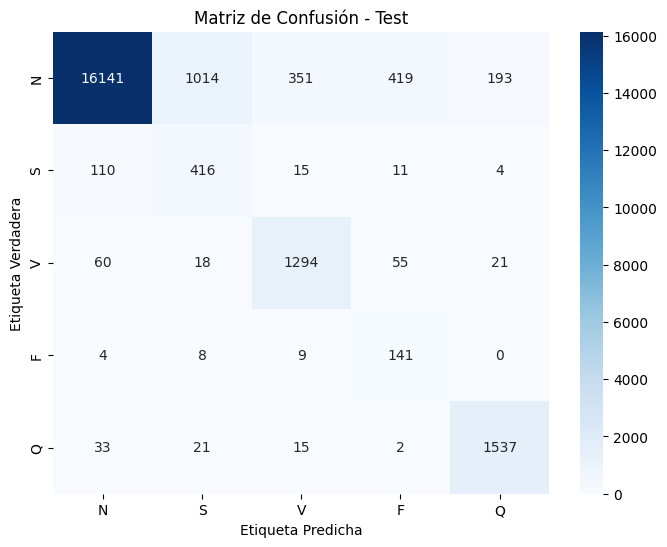

--- Resultados Finales (Test) ---
Loss: 0.3494
Accuracy: 0.8921
F1-Macro: 0.6886
Test Loss: 0.3494, Test F1-score: 0.6886


In [43]:
from types import SimpleNamespace 
best_model_path = "1_best_models/best_lstm_baseline_model.pth"

#load model
config_dict = {"dropout_rate": 0.3, "weight_decay": 0.0001, 
               "optimizer": "Adam", "lr": 0.001879908830170654, 
               "input_size": 1, "hidden_size": 64, 
               "num_layers": 3, "batch_size": 512, 
               "momentum": 0.9, "grad_clip": 5.0}
config_obj = SimpleNamespace(**config_dict)
model = build_ecg_lstm(config_obj) 
model.load_state_dict(torch.load(best_model_path, map_location=device))
model = model.to(device)


_, _, test_loader = get_dataloaders(batch_size=config_obj.batch_size, num_workers=0)

results_sweep_lstm = evaluate_model(model, test_loader, device)
print(f"Test Loss: {results_sweep_lstm['Test_loss']:.4f}, Test F1-score: {results_sweep_lstm['Test_f1_macro']:.4f}")

# 6. Modelo Base GRU

In [35]:
import torch
import torch.nn as nn

SEQ_LENGTH = 187
INPUT_SIZE = 1
NUM_CLASSES = 5 
BATCH_SIZE = 2048

HIDDEN_SIZE = 64  
NUM_LAYERS = 2
DROPOUT_RATE = 0.2

In [36]:
import torch.nn as nn
from types import SimpleNamespace

def build_ecg_gru(cfg, num_classes=5):
    class ECGClassifierGRU(nn.Module):
        def __init__(self, cfg, num_classes):
            super().__init__()
            self.input_size = cfg.input_size
            self.hidden_size = cfg.hidden_size
            self.num_layers = cfg.num_layers
            self.dropout_rate = cfg.dropout_rate

            # GRU apilada (batch_first=True)
            self.rnn = nn.GRU(
                input_size=self.input_size,
                hidden_size=self.hidden_size,
                num_layers=self.num_layers,
                batch_first=True,
                # El dropout funciona igual en GRU
                dropout=self.dropout_rate if self.num_layers > 1 else 0.0
            )

            # Clasificador lineal que recibe la salida del último paso temporal
            self.classifier = nn.Linear(self.hidden_size, num_classes)

        def forward(self, x):
            # x: (batch_size, seq_length, input_size)
            
            # Inicializar h0 (solo se necesita el estado oculto, no el de celda)
            # h0: (num_layers, batch_size, hidden_size)
            h0 = x.new_zeros(self.num_layers, x.size(0), self.hidden_size)

            # GRU devuelve la salida 'out' y el último estado oculto 'h_n'
            out, h_n = self.rnn(x, h0)
            
            # Tomar la salida del último paso temporal para la clasificación
            out_last = out[:, -1, :]  # (batch_size, hidden_size)
            logits = self.classifier(out_last) # (batch_size, num_classes)
            
            return logits

    # Para un sweep o entrenamiento, usarías la misma configuración que en LSTM
    return ECGClassifierGRU(cfg, num_classes=num_classes)


# Configuración equivalente a tus constantes
config = SimpleNamespace(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout_rate=DROPOUT_RATE,
)

model = build_ecg_gru(config, num_classes=NUM_CLASSES)
from torchinfo import summary
summary(model, input_size=(BATCH_SIZE, SEQ_LENGTH, INPUT_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
ECGClassifierGRU                         [2048, 5]                 --
├─GRU: 1-1                               [2048, 187, 64]           37,824
├─Linear: 1-2                            [2048, 5]                 325
Total params: 38,149
Trainable params: 38,149
Non-trainable params: 0
Total mult-adds (G): 14.49
Input size (MB): 1.53
Forward/backward pass size (MB): 196.17
Params size (MB): 0.15
Estimated Total Size (MB): 197.85

## Selección de Hiperparámetros 

In [28]:
def sweep_train():
    """
    Ejecuta un sweep de W&B usando DataLoaders pre-cargados en RAM.
    Sin prints de debug innecesarios.
    """
    wandb.init(
        project="heartbeat", 
        config=wandb.config,
        settings=wandb.Settings(console="off"),
        tags=["BASELINE_GRU"]
    )
    
    config = wandb.config

    # Construir modelo
    model = build_ecg_gru(config).to(device)

    train_loader, val_loader, test_loader = get_dataloaders(
        batch_size=config.batch_size, num_workers=0
    )

    # Entrenamiento
    best_model, history = train_model(
        model, train_loader, val_loader, config, device, patience=7, class_weights=class_weights
    )

    # Guardar modelo
    os.makedirs("models", exist_ok=True)
    local_path = f"models/sweep_run_{wandb.run.id}.pth"
    torch.save(best_model.state_dict(), local_path)

    wandb.finish()


In [ ]:

sweep_config = {
    "name": "gru_sweep_baseline",
    "method": "bayes",
    # Usamos val_f1_macro (que tu train_model loggea) y queremos MAXIMIZARla
    "metric": {"name": "val_f1_macro", "goal": "maximize"},
    "parameters": {
        "input_size": {"value": 1},  # <- fijo para tu GRU univariada

        "lr": {
            "distribution": "log_uniform_values",
            # Se ajusta el rango para priorizar el entorno de la convergencia inicial
            "min": 5e-4, 
            "max": 5e-3 
        },
        # Optimizador: Adam suele funcionar bien con RNNs, SGD con momentum es alternativa
        "optimizer": {"values": ["Adam", "SGD"]},

        # Tamaño de batch (ten en cuenta memoria GPU; tu código soporta varios)
        "batch_size": {"values": [512, 1024]},

        # Arquitectura GRU
        "hidden_size": {"values": [64, 128]},
        "num_layers": {"values": [2, 3]},

        # Dropout en la GRU (cfg.dropout_rate en tu builder)
        "dropout_rate": {"values": [0.0, 0.1, 0.2, 0.3]},

        # Regularización L2
        "weight_decay": {"values": [0.0, 1e-5, 1e-4, 1e-3]},

        # Config del optimizador / entrenamiento
        "momentum": {"values": [0.0, 0.9]},        # usado solo si SGD
        "grad_clip": {"values": [0.0, 1.0, 5.0]},  # 0.0 = sin clip

        # Early stopping / epochs
        "epochs": {"value": 80}, # Aumentamos las épocas
        "patience": {"value": 12}, # Aumentamos la paciencia para evitar Early Stopping prematuro

    }
}

sweep_id = wandb.sweep(sweep_config, project="heartbeat")
wandb.agent(sweep_id, function=sweep_train, count=30)


![image.png](assets/gru.png)

In [30]:
upload_best_model_from_sweep(
    sweep_id="fksribz7",
    model_name="best_model_gru_baseline",
    project="heartbeat",
)

• helpful-sweep-1 (hquki08l) → val_f1_macro = 0.06124735533818922
• eager-sweep-2 (9v7kvfnp) → val_f1_macro = 0.721587910270802
• balmy-sweep-3 (cgx9oz8f) → val_f1_macro = 0.7431497155814965
• zesty-sweep-4 (l751c0v7) → val_f1_macro = 0.07182660133669728
• glowing-sweep-5 (spzr3158) → val_f1_macro = 0.22116901500627265
• avid-sweep-6 (i7o110aj) → val_f1_macro = 0.05690954979313052
• brisk-sweep-7 (3aj7iw40) → val_f1_macro = 0.6847224144749646
• fresh-sweep-8 (dnepellq) → val_f1_macro = 0.21330330999759192
• stoic-sweep-9 (0w3wirnd) → val_f1_macro = 0.6713332196248215
• firm-sweep-10 (whqcre9d) → val_f1_macro = 0.6938379403429857
• major-sweep-11 (h2dszx7z) → val_f1_macro = 0.5558148058789771
• scarlet-sweep-12 (zcppmnpl) → val_f1_macro = 0.7583692858508176
• different-sweep-13 (zq7zrafa) → val_f1_macro = 0.7557856243754033
• noble-sweep-14 (n9vpb5aq) → val_f1_macro = 0.6612050267930134
• bright-sweep-15 (ncr8j8ob) → val_f1_macro = 0.6855923733299428
• sleek-sweep-16 (uxsgb4tw) → val_f1


✅ Artifact 'best_model_gru_baseline_best_model_fksribz7' subido correctamente a W&B.


## Evaluación en Test


--- Verificación de Estructura de DataLoaders ---
Batches de Entrenamiento (train_loader): 69
Batches de Validación (val_loader): 18
Batches de Prueba (test_loader): 22

Tensor de Validación (Batch): torch.Size([1024, 187, 1])
Formato esperado para RNN/LSTM: (BATCH_SIZE, 187, 1)

Iniciando evaluación en el conjunto: Test...

Classification Report:

              precision    recall  f1-score   support

           N       0.99      0.93      0.96     18118
           S       0.41      0.82      0.54       556
           V       0.85      0.94      0.89      1448
           F       0.27      0.93      0.42       162
           Q       0.92      0.98      0.95      1608

    accuracy                           0.93     21892
   macro avg       0.69      0.92      0.75     21892
weighted avg       0.96      0.93      0.94     21892



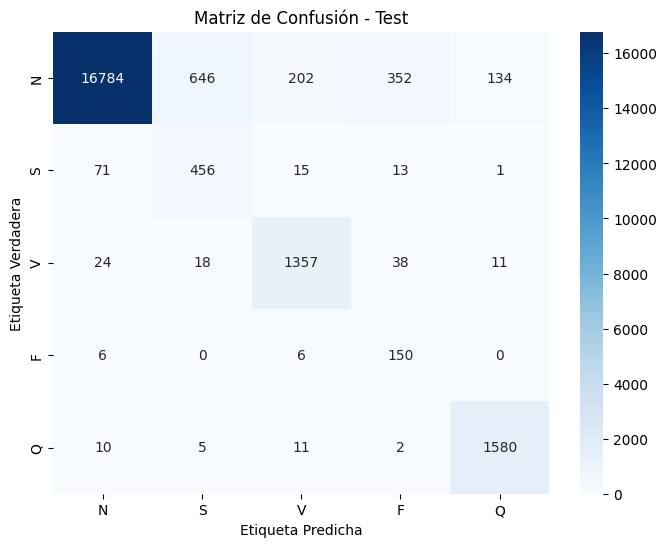

--- Resultados Finales (Test) ---
Loss: 0.2231
Accuracy: 0.9285
F1-Macro: 0.7521
Test Loss: 0.2231, Test F1-score: 0.7521


In [44]:
from types import SimpleNamespace 
best_model_path = "1_best_models/best_gru_baseline_model.pth"

#load model
config_dict = {"dropout_rate": 0.1, "weight_decay": 0.0, 
               "optimizer": "Adam", "lr": 0.0015510926725570548, 
               "input_size": 1, "hidden_size": 128, 
               "num_layers": 3, "batch_size": 1024, 
               "momentum": 0.9, "grad_clip": 1.0}
config_obj = SimpleNamespace(**config_dict)
model = build_ecg_gru(config_obj) 
model.load_state_dict(torch.load(best_model_path, map_location=device))
model = model.to(device)


_, _, test_loader = get_dataloaders(batch_size=config_obj.batch_size, num_workers=0)

results_sweep_gru = evaluate_model(model, test_loader, device)
print(f"Test Loss: {results_sweep_gru['Test_loss']:.4f}, Test F1-score: {results_sweep_gru['Test_f1_macro']:.4f}")

# 7. Modelo CNN + GRU

In [38]:
import torch
import torch.nn as nn

SEQ_LENGTH = 187
INPUT_SIZE = 1
NUM_CLASSES = 5 
BATCH_SIZE = 2048

HIDDEN_SIZE = 64  
NUM_LAYERS = 2
DROPOUT_RATE = 0.2

In [39]:
import torch.nn as nn

def build_ecg_cnngru(cfg, num_classes=5):
    class ECGClassifierCNNGRU(nn.Module):
        def __init__(self, cfg, num_classes):
            super().__init__()
            self.input_size = cfg.input_size
            self.hidden_size = cfg.hidden_size
            self.num_layers = cfg.num_layers
            self.dropout_rate = cfg.dropout_rate
            
            # --- 1. Bloque de Extracción de Características (Conv1D) ---
            # Conv1D es excelente para series de tiempo (187, 1)
            self.conv1 = nn.Conv1d(
                in_channels=self.input_size, 
                out_channels=32,          # 32 filtros
                kernel_size=5,            # Filtro pequeño para patrones locales
                padding='same'
            )
            self.relu = nn.ReLU()
            self.pool = nn.MaxPool1d(kernel_size=2) # Reduce la longitud de la secuencia a la mitad (187 -> 93)
            
            # --- 2. Bloque Recurrente (GRU) ---
            # El nuevo input_size es el número de canales de salida del Conv1D (32)
            self.rnn = nn.GRU(
                input_size=32, 
                hidden_size=self.hidden_size,
                num_layers=self.num_layers,
                batch_first=True,
                dropout=self.dropout_rate if self.num_layers > 1 else 0.0
            )

            # --- 3. Clasificador Final ---
            self.classifier = nn.Linear(self.hidden_size, num_classes)

        def forward(self, x):
            # x: (B, L=187, H=1). Conv1D espera (B, H, L)
            
            # 1. Reordenar para Conv1D: (B, L, H) -> (B, H, L) = (Batch, 1, 187)
            x_conv = x.permute(0, 2, 1) 
            
            # 2. Bloque Conv: (B, 1, 187) -> (B, 32, 187) -> (B, 32, 93)
            x_conv = self.pool(self.relu(self.conv1(x_conv)))
            
            # 3. Reordenar para GRU: (B, H, L_nueva) -> (B, L_nueva, H) = (Batch, 93, 32)
            x_rnn = x_conv.permute(0, 2, 1) 
            
            # 4. GRU: (B, 93, 32) -> out (B, 93, hidden_size)
            h0 = x_rnn.new_zeros(self.num_layers, x_rnn.size(0), self.hidden_size)
            out, _ = self.rnn(x_rnn, h0)
            
            # 5. Clasificación
            out_last = out[:, -1, :]
            logits = self.classifier(out_last)
            
            return logits

    return ECGClassifierCNNGRU(cfg, num_classes=num_classes)

#summary
from types import SimpleNamespace
config = SimpleNamespace(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout_rate=DROPOUT_RATE,
)
model = build_ecg_cnngru(config, num_classes=NUM_CLASSES)
from torchinfo import summary
summary(model, input_size=(BATCH_SIZE, SEQ_LENGTH, INPUT_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
ECGClassifierCNNGRU                      [2048, 5]                 --
├─Conv1d: 1-1                            [2048, 32, 187]           192
├─ReLU: 1-2                              [2048, 32, 187]           --
├─MaxPool1d: 1-3                         [2048, 32, 93]            --
├─GRU: 1-4                               [2048, 93, 64]            43,776
├─Linear: 1-5                            [2048, 5]                 325
Total params: 44,293
Trainable params: 44,293
Non-trainable params: 0
Total mult-adds (G): 8.41
Input size (MB): 1.53
Forward/backward pass size (MB): 195.64
Params size (MB): 0.18
Estimated Total Size (MB): 197.35

## Selección de Hiperparámetros

In [14]:
def sweep_train():
    """
    Ejecuta un sweep de W&B usando DataLoaders pre-cargados en RAM.
    Sin prints de debug innecesarios.
    """
    wandb.init(
        project="heartbeat", 
        config=wandb.config,
        settings=wandb.Settings(console="off"),
        tags=["BASELINE_CNN_GRU"]
    )
    
    config = wandb.config

    # Construir modelo
    model = build_ecg_cnngru(config).to(device)

    train_loader, val_loader, test_loader = get_dataloaders(
        batch_size=config.batch_size, num_workers=0
    )

    # Entrenamiento
    best_model, history = train_model(
        model, train_loader, val_loader, config, device, patience=7, class_weights=class_weights
    )

    # Guardar modelo
    os.makedirs("models", exist_ok=True)
    local_path = f"models/sweep_run_{wandb.run.id}.pth"
    torch.save(best_model.state_dict(), local_path)

    wandb.finish()


In [ ]:

sweep_config = {
    "name": "cnn_gru_sweep_baseline",
    "method": "bayes",
    # Usamos val_f1_macro (que tu train_model loggea) y queremos MAXIMIZARla
    "metric": {"name": "val_f1_macro", "goal": "maximize"},
    "parameters": {
        "input_size": {"value": 1},  # <- fijo para tu GRU univariada

        "lr": {
            "distribution": "log_uniform_values",
            # Se ajusta el rango para priorizar el entorno de la convergencia inicial
            "min": 5e-4, 
            "max": 5e-3 
        },
        # Optimizador: Adam suele funcionar bien con RNNs, SGD con momentum es alternativa
        "optimizer": {"values": ["Adam", "SGD"]},

        # Tamaño de batch (ten en cuenta memoria GPU; tu código soporta varios)
        "batch_size": {"values": [512, 1024]},

        # Arquitectura GRU
        "hidden_size": {"values": [64, 128]},
        "num_layers": {"values": [2, 3]},

        # Dropout en la GRU (cfg.dropout_rate en tu builder)
        "dropout_rate": {"values": [0.0, 0.1, 0.2, 0.3]},

        # Regularización L2
        "weight_decay": {"values": [0.0, 1e-5, 1e-4, 1e-3]},

        # Config del optimizador / entrenamiento
        "momentum": {"values": [0.0, 0.9]},        # usado solo si SGD
        "grad_clip": {"values": [0.0, 1.0, 5.0]},  # 0.0 = sin clip

        # Early stopping / epochs
        "epochs": {"value": 80}, # Aumentamos las épocas
        "patience": {"value": 12}, # Aumentamos la paciencia para evitar Early Stopping prematuro

    }
}

sweep_id = wandb.sweep(sweep_config, project="heartbeat")
wandb.agent(sweep_id, function=sweep_train, count=30)


![image.png](assets/cnn_gru.png)

In [16]:
upload_best_model_from_sweep(
    sweep_id="9p3x00ug",
    model_name="best_model_cnn_gru_baseline",
    project="heartbeat",
)

• serene-sweep-1 (o6mjs4uz) → val_f1_macro = 0.22712145202222625
• playful-sweep-2 (zde8bz6o) → val_f1_macro = 0.0651166188873659
• youthful-sweep-3 (lzqykkjs) → val_f1_macro = 0.6430249721532514
• charmed-sweep-4 (ee0okyof) → val_f1_macro = 0.05811635418293361
• genial-sweep-5 (67xhcd7q) → val_f1_macro = 0.7049069439387634
• grateful-sweep-6 (scb65lid) → val_f1_macro = 0.21097286150416655
• ancient-sweep-7 (akeniesy) → val_f1_macro = 0.7124368432416678
• glowing-sweep-8 (7ywv4rk9) → val_f1_macro = 0.0700880184365396
• treasured-sweep-9 (i4m7fl16) → val_f1_macro = 0.6925448990158076
• zesty-sweep-10 (p9kp9kd1) → val_f1_macro = 0.6798825612580707
• colorful-sweep-11 (0nzgpmj7) → val_f1_macro = 0.733056190799165
• sandy-sweep-12 (y19taro3) → val_f1_macro = 0.2354800620439886
• pleasant-sweep-13 (xc0vhhn2) → val_f1_macro = 0.7044849820901214
• kind-sweep-14 (5go79cnv) → val_f1_macro = 0.693171536929425
• stellar-sweep-15 (fuk507ws) → val_f1_macro = 0.7549102355389149
• light-sweep-16 (bak

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.



✅ Artifact 'best_model_cnn_gru_baseline_best_model_9p3x00ug' subido correctamente a W&B.


## Evaluación en Test


--- Verificación de Estructura de DataLoaders ---
Batches de Entrenamiento (train_loader): 69
Batches de Validación (val_loader): 18
Batches de Prueba (test_loader): 22

Tensor de Validación (Batch): torch.Size([1024, 187, 1])
Formato esperado para RNN/LSTM: (BATCH_SIZE, 187, 1)

Iniciando evaluación en el conjunto: Test...

Classification Report:

              precision    recall  f1-score   support

           N       0.99      0.93      0.96     18118
           S       0.41      0.80      0.55       556
           V       0.86      0.95      0.90      1448
           F       0.29      0.94      0.44       162
           Q       0.95      0.98      0.97      1608

    accuracy                           0.94     21892
   macro avg       0.70      0.92      0.76     21892
weighted avg       0.96      0.94      0.94     21892



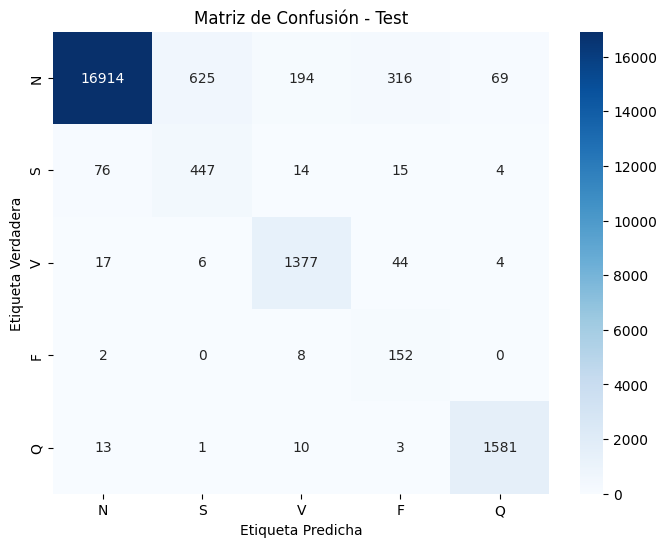

--- Resultados Finales (Test) ---
Loss: 0.1940
Accuracy: 0.9351
F1-Macro: 0.7639
Test Loss: 0.1940, Test F1-score: 0.7639


In [45]:
from types import SimpleNamespace 
best_model_path = "1_best_models/best_cnn_gru_baseline_model.pth"

#load model
config_dict = {"dropout_rate": 0.2, "weight_decay": 0.0, 
               "optimizer": "Adam", "lr": 0.0012977145633402691, 
               "input_size": 1, "hidden_size": 128, 
               "num_layers": 3, "batch_size": 1024, 
               "momentum": 0.9, "grad_clip": 5.0}
config_obj = SimpleNamespace(**config_dict)
model = build_ecg_cnngru(config_obj) 
model.load_state_dict(torch.load(best_model_path, map_location=device))
model = model.to(device)


_, _, test_loader = get_dataloaders(batch_size=config_obj.batch_size, num_workers=0)

results_sweep_cnn_gru = evaluate_model(model, test_loader, device)
print(f"Test Loss: {results_sweep_cnn_gru['Test_loss']:.4f}, Test F1-score: {results_sweep_cnn_gru['Test_f1_macro']:.4f}")

# 8. ResNet 1D

In [26]:
import torch
import torch.nn as nn
from types import SimpleNamespace

# --- 1. Bloque Residual Básico 1D ---
# Componente clave de la ResNet
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, kernel_size=5):
        super().__init__()
        
        # El bloque principal: Conv -> BN -> ReLU -> Conv -> BN
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, 
                               stride=stride, padding=kernel_size//2, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, 
                               stride=1, padding=kernel_size//2, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        # Conexión de atajo (Shortcut/Skip Connection)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(identity)
        out = self.relu(out)
        return out

# --- 2. Función de Construcción ---
def build_ecg_resnet1d(cfg, num_classes=5):
    
    class ECGClassifierResNet1D(nn.Module):
        def __init__(self, cfg, num_classes):
            super().__init__()
            # in_channels_start es un hiperparámetro para el sweep
            self.in_channels = cfg.in_channels_start 

            # Capa Inicial: x: (B, 1, 187) -> (B, in_channels, ~94)
            self.initial_conv = nn.Sequential(
                nn.Conv1d(cfg.input_size, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False),
                nn.BatchNorm1d(self.in_channels),
                nn.ReLU(inplace=True)
            )
            
            # Stack de Bloques Residuales (Definición de etapas)
            self.layer1 = self._make_layer(ResidualBlock1D, 64, cfg.blocks_per_layer, stride=1)
            self.layer2 = self._make_layer(ResidualBlock1D, 128, cfg.blocks_per_layer, stride=2)
            self.layer3 = self._make_layer(ResidualBlock1D, 256, cfg.blocks_per_layer, stride=2)

            # Capa de Pooling Global y Clasificador
            self.avgpool = nn.AdaptiveAvgPool1d(1) 
            self.fc = nn.Linear(256, num_classes)
            
        def _make_layer(self, block, out_channels, num_blocks, stride):
            # Lógica para construir una etapa de la red (secuencia de bloques)
            strides = [stride] + [1] * (num_blocks - 1)
            layers = []
            for stride_step in strides:
                layers.append(block(self.in_channels, out_channels, stride_step))
                self.in_channels = out_channels # Crucial: actualiza in_channels para el siguiente bloque
            return nn.Sequential(*layers)

        def forward(self, x):
            # 1. Reordenar para Conv1D: (B, L, H) -> (B, H, L) = (Batch, 1, 187)
            x = x.permute(0, 2, 1) 
            
            # 2. Bloques
            x = self.initial_conv(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            
            # 3. Clasificación
            x = self.avgpool(x)
            x = x.view(x.size(0), -1) 
            logits = self.fc(x)
            return logits

    return ECGClassifierResNet1D(cfg, num_classes=num_classes)

RESNET_CONFIG_EXAMPLE = SimpleNamespace(
    input_size=1,
    in_channels_start=64,    # Canales de salida del Conv inicial
    blocks_per_layer=2,      # Profundidad de cada etapa (Total: 6 bloques)
)

#SUMMARY
model = build_ecg_resnet1d(RESNET_CONFIG_EXAMPLE, num_classes=NUM_CLASSES)
from torchinfo import summary
summary(model, input_size=(1, 187, 1))

Layer (type:depth-idx)                   Output Shape              Param #
ECGClassifierResNet1D                    [1, 5]                    --
├─Sequential: 1-1                        [1, 64, 94]               --
│    └─Conv1d: 2-1                       [1, 64, 94]               448
│    └─BatchNorm1d: 2-2                  [1, 64, 94]               128
│    └─ReLU: 2-3                         [1, 64, 94]               --
├─Sequential: 1-2                        [1, 64, 94]               --
│    └─ResidualBlock1D: 2-4              [1, 64, 94]               --
│    │    └─Conv1d: 3-1                  [1, 64, 94]               20,480
│    │    └─BatchNorm1d: 3-2             [1, 64, 94]               128
│    │    └─ReLU: 3-3                    [1, 64, 94]               --
│    │    └─Conv1d: 3-4                  [1, 64, 94]               20,480
│    │    └─BatchNorm1d: 3-5             [1, 64, 94]               128
│    │    └─Sequential: 3-6              [1, 64, 94]               --
│  

## Selección de Hiperparámetros

In [16]:
def sweep_train():
    """
    Ejecuta un sweep de W&B usando DataLoaders pre-cargados en RAM.
    Sin prints de debug innecesarios.
    """
    wandb.init(
        project="heartbeat", 
        config=wandb.config,
        settings=wandb.Settings(console="off"),
        tags=["BASELINE_RESNET1D"]
    )
    
    config = wandb.config

    # Construir modelo
    model = build_ecg_resnet1d(config).to(device)

    train_loader, val_loader, test_loader = get_dataloaders(
        batch_size=config.batch_size, num_workers=0
    )

    # Entrenamiento
    best_model, history = train_model(
        model, train_loader, val_loader, config, device, patience=8, class_weights=class_weights
    )

    # Guardar modelo
    os.makedirs("models", exist_ok=True)
    local_path = f"models/sweep_run_{wandb.run.id}.pth"
    torch.save(best_model.state_dict(), local_path)

    wandb.finish()


In [17]:
resnet_sweep_config = {
    "name": "resnet1d_sweep_final",
    "method": "bayes",
    "metric": {"name": "val_f1_macro", "goal": "maximize"},
    "parameters": {
        "input_size": {"value": 1}, 

        # --- ARQUITECTURA RESNET-1D (Sustituye a GRU/LSTM HPs) ---
        "in_channels_start": {"values": [32, 64]},     # Canales de salida de la capa inicial (afecta el ancho)
        "blocks_per_layer": {"values": [1, 2, 3]},     # Cantidad de bloques residuales por etapa (afecta la profundidad)
        
        # El Dropout ya no va en la capa recurrente, pero se puede usar en la capa lineal
        "dropout_rate": {"values": [0.0, 0.1, 0.2, 0.3]},

        # --- PARÁMETROS DE APRENDIZAJE ---
        "lr": {
            "distribution": "log_uniform_values",
            "min": 5e-4, 
            "max": 5e-3 
        },
        "optimizer": {"values": ["Adam", "SGD"]},
        "batch_size": {"values": [512, 1024]},
        "weight_decay": {"values": [0.0, 1e-5, 1e-4, 1e-3]},

        # --- REGULARIZACIÓN Y ENTRENAMIENTO ---
        "momentum": {"values": [0.0, 0.9]}, 
        "grad_clip": {"values": [0.0, 1.0, 5.0]}, # Es menos crítico que en RNN, pero útil para estabilidad
        "epochs": {"value": 80}, 
        "patience": {"value": 15}, # Aumentamos la paciencia por ser una red más profunda
    }
}

In [ ]:
sweep_id = wandb.sweep(resnet_sweep_config, project="heartbeat")
wandb.agent(sweep_id, function=sweep_train, count=10)

![image.png](assets/resnet.png)

In [27]:
upload_best_model_from_sweep(
    sweep_id="cgb5tqku",
    model_name="best_model_resnet_baseline",
    project="heartbeat",
)

• helpful-sweep-1 (9kady2te) → val_f1_macro = 0.8870888014829654
• sparkling-sweep-2 (q9jni6zp) → val_f1_macro = 0.7929157322811713
• peach-sweep-3 (zktkrsmh) → val_f1_macro = 0.9043841395911204
• cosmic-sweep-4 (1gjzzss5) → val_f1_macro = 0.7995204588363755
• earthy-sweep-5 (rpf1ivwz) → val_f1_macro = 0.9319112928484332
• misty-sweep-6 (tkqublni) → val_f1_macro = 0.7675810118131732
• efficient-sweep-7 (haufh228) → val_f1_macro = 0.9170404655671096
• smart-sweep-8 (xmo5gidd) → val_f1_macro = 0.9182387370410894
• wise-sweep-9 (ycmvrc1r) → val_f1_macro = 0.9148416717884604
• treasured-sweep-10 (7ow56m8q) → val_f1_macro = 0.8377527701175952

🏆 Mejor run encontrada:
   • Run: earthy-sweep-5 (rpf1ivwz)
   • val_f1_macro = 0.9319
   • Sweep ID: cgb5tqku


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.



✅ Artifact 'best_model_resnet_baseline_best_model_cgb5tqku' subido correctamente a W&B.


## Evaluación en Test


--- Verificación de Estructura de DataLoaders ---
Batches de Entrenamiento (train_loader): 69
Batches de Validación (val_loader): 18
Batches de Prueba (test_loader): 22

Tensor de Validación (Batch): torch.Size([1024, 187, 1])
Formato esperado para RNN/LSTM: (BATCH_SIZE, 187, 1)

Iniciando evaluación en el conjunto: Test...

Classification Report:

              precision    recall  f1-score   support

           N       0.99      1.00      0.99     18118
           S       0.91      0.79      0.85       556
           V       0.97      0.96      0.96      1448
           F       0.85      0.85      0.85       162
           Q       0.99      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.94      0.92      0.93     21892
weighted avg       0.99      0.99      0.99     21892



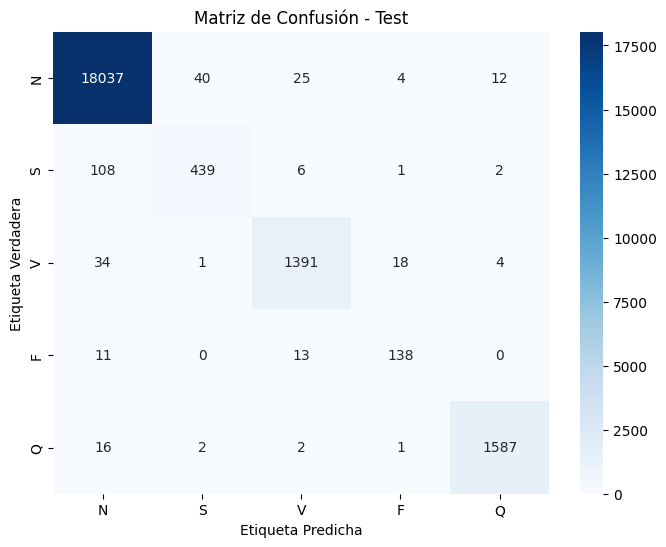

--- Resultados Finales (Test) ---
Loss: 0.0679
Accuracy: 0.9863
F1-Macro: 0.9286
Test Loss: 0.0679, Test F1-score: 0.9286


In [46]:
from types import SimpleNamespace 
best_model_path = "1_best_models/best_resnet_baseline_model.pth"

#load model
config_dict = {"dropout_rate": 0.0, "weight_decay": 0.0, 
               "optimizer": "SGD", "lr": 0.0014043431299565442, 
               "input_size": 1, "blocks_per_layer": 3, 
               "in_channels_start": 64, "batch_size": 1024, 
               "momentum": 0.9, "grad_clip": 1.0}
config_obj = SimpleNamespace(**config_dict)
model = build_ecg_resnet1d(config_obj) 
model.load_state_dict(torch.load(best_model_path, map_location=device))
model = model.to(device)


_, _, test_loader = get_dataloaders(batch_size=config_obj.batch_size, num_workers=0)

results_sweep_resnet1d = evaluate_model(model, test_loader, device)
print(f"Test Loss: {results_sweep_resnet1d['Test_loss']:.4f}, Test F1-score: {results_sweep_resnet1d['Test_f1_macro']:.4f}")

# 9. Comparativa de Modelos

In [47]:
#make a dataframe comparing all results
import pandas as pd
results_df = pd.DataFrame({
    "Model": ["LSTM Baseline", "GRU Baseline", "CNN-GRU Baseline", "ResNet1D Baseline"],
    "Test Loss": [
        results_sweep_lstm["Test_loss"],
        results_sweep_gru["Test_loss"],
        results_sweep_cnn_gru["Test_loss"],
        results_sweep_resnet1d["Test_loss"]
    ],
    "Test F1-score": [
        results_sweep_lstm["Test_f1_macro"],
        results_sweep_gru["Test_f1_macro"],
        results_sweep_cnn_gru["Test_f1_macro"],
        results_sweep_resnet1d["Test_f1_macro"]
    ]
})

results_df

Model  Test Loss  Test F1-score
0      LSTM Baseline   0.349352       0.688643
1       GRU Baseline   0.223117       0.752108
2   CNN-GRU Baseline   0.193989       0.763914
3  ResNet1D Baseline   0.067868       0.928597

# 10. Conclusiones

Resumen breve
- Se trabajó con el Heartbeat Dataset (mitbih_train / mitbih_test) y se implementaron desde cero modelos basados en RNN (LSTM y GRU), un híbrido CNN+GRU y una arquitectura ResNet1D, sin usar modelos pre-entrenados.
- Se registraron y monitorizaron experimentos con Weights & Biases (wandb) y se guardaron pesos de los mejores runs en disco para evaluación reproducible.

Principales hallazgos del EDA
- El dataset está fuertemente desbalanceado: la clase N (Normal) domina (~82.77% de las muestras). Este hecho hace que la métrica accuracy sea poco informativa por sí sola.
- Las formas de las señales muestran variabilidad por clase; la media y desviación por clase revelan diferencias en la morfología que justifican usar modelos secuenciales capaces de modelar dependencia temporal.
- La distribución global de amplitudes presenta un pico marcado alrededor de 0.0; por eso se optó por normalización Z-score global para estabilizar entrenamiento y acelerar convergencia.

Decisiones de preprocesamiento y justificación
- Normalización Z-score global usando la media y desviación estándar del conjunto de entrenamiento (evita fuite de información del test).
- División estratificada (train / val) para preservar el desbalance relativo entre splits.
- Cálculo de pesos inversos por clase y uso de `nn.CrossEntropyLoss(weight=class_weights)` para mitigar el sesgo hacia la clase mayoritaria.
- Reformateo de señales a la forma (batch, seq_length, 1) adecuada para RNNs; para CNN1D se reordena a (batch, channels, length).

Resultados y observaciones sobre modelos
- Se entrenaron y compararon: LSTM (apilada), GRU (apilada), CNN + GRU (conv1d + pooling + GRU) y ResNet1D (bloques residuales 1D).
- Diseño experimental: sweeps Bayesianos en wandb para explorar lr, batch_size, hidden_size, num_layers, dropout, weight_decay y clipping; early stopping basado en F1-macro de validación.
- Observaciones cualitativas:
  - Las RNN (LSTM/GRU) aprenden dependencias temporales y funcionan bien con latidos completos; GRU ofrece una alternativa más ligera con comportamiento similar en muchos casos.
  - El bloque CNN antes de la GRU mejora la extracción de características locales (picos, morfologías) y suele acelerar la convergencia.
  - ResNet1D, al usar convoluciones profundas y skip connections, es robusto para características jerárquicas y puede superar a RNNs cuando las relaciones locales/jerárquicas son clave.


Finalmente, el mejor modelo fue el ResNet1D, logrando un F1-macro superior en test.


